# Progetto Tesi Calciatori Under 21

## Importazione librerie

In [102]:
import requests
from bs4 import BeautifulSoup as soup
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import seaborn as sns
import time
from request_get import *
from datetime import datetime
from dateutil import relativedelta
import statsmodels.api as sm
from scipy.stats import f_oneway,kstest
from scipy import stats
import numpy as np

## Importazione dataset

In [231]:
# le funzioni che seguono servono a prendere i dati da fbref e transfermarkt e salvarli in un file xlsx (definite nel file request_get.py)
#get_fbref()
#get_transfermarkt()

In [339]:
"""Estrae per ogni anno la data della prima giornata di Serie A, non usata perchè si è scelto il 1 Agosto come data di inizio"""

"""
current_year = 2022
year_to_subtract = 33
prima_giornata = pd.DataFrame(columns=["Stagione","Prima giornata"])
for i in range(year_to_subtract):
    year_url = f"{current_year - i}"
    url = f"https://www.transfermarkt.it/serie-a/spieltag/wettbewerb/IT1/plus/?saison_id={year_url}&spieltag=1"
    headers = {'User-Agent': 
                    'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}
    r= requests.get(url, headers=headers)
    r.status_code  

    soups = soup(r.text, 'html.parser')  # r.content 대신 r.text도 가능
    page=soups.find('td', class_=['zentriert no-border'])
    prima_giornata.loc[year_url,"Prima giornata"]=page.find('a').text.strip()"""



## Estrazione minuti di gioco

In [47]:
# Calcola i minuti giocati dai giocatori under 21 per ogni anno, stabilendo come under 21 i giocatori nati dopo il 1 Agosto 
mesi = {
    "gen": 1, "feb": 2, "mar": 3, "apr": 4, "mag": 5, "giu": 6, "lug": 7, "ago": 8, "set": 9, "ott": 10, "nov": 11, "dic": 12
}
mins_played=pd.DataFrame(columns=["Minuti giocati FIX","Minuti giocati Italiani","Minuti giocati Stranieri"])
current_year = 2022

# Define the number of years you want to subtract
year_to_subtract = 54

for i in range(year_to_subtract):
    # Calculate the year to use in the URL
    year_url = f"{current_year - i}-{current_year + 1 - i}"
    
    
    #players_fbref=pd.read_excel(f"fbref\SerieA{year_url}-Under21.xlsx")
    players_tm=pd.read_excel(f"transfermarkt\SerieA{year_url}-Under21.xlsx")
    for j in range(len(players_tm)):
        parti = players_tm.loc[j,"Nato"].split('/')
        giorno_nasc = int(parti[0])
        mese_nasc = mesi[parti[1].lower()]  # Mappa il mese in minuscolo
        anno_nasc = int(parti[2])
        data_nasc = datetime(anno_nasc, mese_nasc, giorno_nasc)
        players_tm.loc[j,"Data di nascita"]=data_nasc
        data_inizio=datetime(current_year-i, 8, 1)
        anni=relativedelta.relativedelta(data_inizio, data_nasc).years
        players_tm.loc[j,"Anni"]=anni
    under=players_tm[players_tm["Anni"]<21]
    under_italia=under[under["Nazione"]=="Italia"]
    under_stranieri=under[under["Nazione"]!="Italia"]
    mins_played.loc[year_url,"Minuti giocati Italiani"]=under_italia["Minuti giocati"].sum()
    mins_played.loc[year_url,"Minuti giocati FIX"]=under["Minuti giocati"].sum()
    mins_played.loc[year_url,"Minuti giocati Stranieri"]=under_stranieri["Minuti giocati"].sum()
    #count the number of mins played by player with nAtionality NOT Italy
    

    #mins_played.loc[year_url,"Minuti giocati FB"]=players_fbref["Minuti giocati"].sum()
    #mins_played.loc[year_url,"Minuti giocati TM"]=players_tm["Minuti giocati"].sum()
    #mins_played.loc[year_url,"TM - FB"]=mins_played.loc[year_url,"Minuti giocati FIX"]-mins_played.loc[year_url,"Minuti giocati FB"]




In [43]:
mins_played.head()

,Minuti giocati FIX,Minuti giocati Italiani,Minuti giocati Stranieri
2022-2023,45572,22898,22674
2021-2022,43060,17242,25818
2020-2021,44079,13824,30255
2019-2020,46669,19584,27085
2018-2019,58666,18945,39721
2017-2018,51306,31215,20091
2016-2017,48348,20533,27815
2015-2016,35956,16155,19801
2014-2015,41981,20895,21086
2013-2014,46824,18341,28483


### Normalizzazione minuti di gioco

In [48]:
#normalize Minuti giocati to total minutes played in the league and create another column(from 2022-2023 to 2004-2005 divided for 3420 minutes, from 2003-2004 to 1988-1989 divided for 3060 minutes and from 1987-1988 to 1968-1969 divided for 2700 minutes)
#mins_played["Minuti giocati normalizzati Fbref"]=0
mins_played=mins_played.iloc[::-1]

mins_played["Minuti giocati normalizzati Italiani"]=0
mins_played["Minuti giocati normalizzati Stranieri"]=0
mins_played["Minuti giocati normalizzati FIX"]=0
mins_played["Minuti giocati totali"]=0


#mins_played["Minuti giocati normalizzati Fbref"][0:19]=mins_played["Minuti giocati FBref"][0:19]/3420
#mins_played["Minuti giocati normalizzati Fbref"][19:35]=mins_played["Minuti giocati FBref"][19:35]/3060
#mins_played["Minuti giocati normalizzati Fbref"][35:]=mins_played["Minuti giocati FBref"][35:]/2700
mins_played["Minuti giocati normalizzati Italiani"][0:19]=mins_played["Minuti giocati Italiani"][0:19]/(90*11*30*20)*100
mins_played["Minuti giocati normalizzati Italiani"][19:35]=mins_played["Minuti giocati Italiani"][19:35]/(90*11*34*20)*100
mins_played["Minuti giocati normalizzati Italiani"][35:]=mins_played["Minuti giocati Italiani"][35:]/(90*11*38*20)*100


mins_played["Minuti giocati normalizzati Stranieri"][0:19]=mins_played["Minuti giocati Stranieri"][0:19]/(90*11*30*20)*100
mins_played["Minuti giocati normalizzati Stranieri"][19:35]=mins_played["Minuti giocati Stranieri"][19:35]/(90*11*34*20)*100
mins_played["Minuti giocati normalizzati Stranieri"][35:]=mins_played["Minuti giocati Stranieri"][35:]/(90*11*38*20)*100

mins_played["Minuti giocati normalizzati FIX"][0:19]=mins_played["Minuti giocati FIX"][0:19]/(90*11*30*20)*(100)
mins_played["Minuti giocati normalizzati FIX"][19:35]=mins_played["Minuti giocati FIX"][19:35]/(90*11*34*20)*100
mins_played["Minuti giocati normalizzati FIX"][35:]=mins_played["Minuti giocati FIX"][35:]/(90*11*38*20)*100

mins_played["Minuti giocati totali"][0:19]=594000
mins_played["Minuti giocati totali"][19:35]=673200
mins_played["Minuti giocati totali"][35:]=752400

#convert ["Minuti giocati normalizzati FIX"] in float
mins_played["Minuti giocati normalizzati FIX"]=mins_played["Minuti giocati normalizzati FIX"].astype(float)
mins_played["Minuti giocati FIX"]=mins_played["Minuti giocati FIX"].astype(float)
mins_played["Minuti giocati normalizzati Italiani"]=mins_played["Minuti giocati normalizzati Italiani"].astype(float)


In [79]:
mins_played.tail()

,Minuti giocati FIX,Minuti giocati Italiani,Minuti giocati Stranieri,Minuti giocati normalizzati Italiani,Minuti giocati normalizzati Stranieri,Minuti giocati normalizzati FIX,Minuti giocati totali
2018-2019,58666.0,18945,39721,2.517943,5.27924,7.797182,752400
2019-2020,46669.0,19584,27085,2.602871,3.599814,6.202685,752400
2020-2021,44079.0,13824,30255,1.837321,4.021132,5.858453,752400
2021-2022,43060.0,17242,25818,2.291600,3.431419,5.723020,752400
2022-2023,45572.0,22898,22674,3.043328,3.013557,6.056885,752400


In [32]:
#modify the index of mins_played and get only the first part(examples: 2022-2023 becomes 2022, 2021-2022 becomes 2021)
mins_played.index=mins_played.index.str[:4]



In [33]:
#convert the index of mins_played to DateTime
mins_played.index=pd.to_datetime(mins_played.index, format='%Y')

In [34]:
mins_played["Minuti giocati normalizzati FIX"].describe()

count    54.000000
mean      5.858159
std       1.345997
min       3.509804
25%       4.952726
50%       5.672116
75%       6.420986
max      10.101852
Name: Minuti giocati normalizzati FIX, dtype: float64

## Test statistici

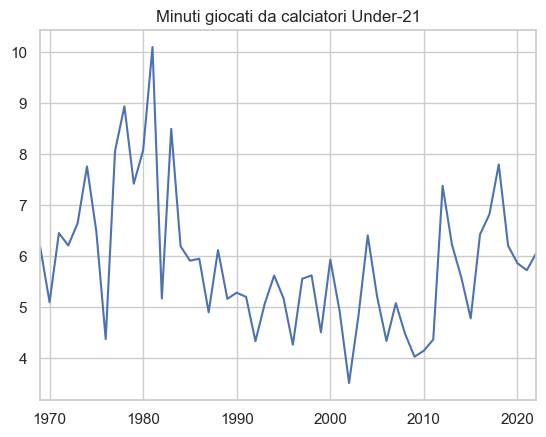

C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:     Minuti giocati normalizzati FIX   No. Observations:                   54
Model:                              ARIMA(1, 1, 1)   Log Likelihood                 -84.948
Date:                             Tue, 24 Oct 2023   AIC                            175.895
Time:                                     18:10:55   BIC                            181.806
Sample:                                 01-01-1969   HQIC                           178.169
                                      - 01-01-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0083      0.196     -0.042      0.966      -0.392       0.376
ma.L1         -0.6765      

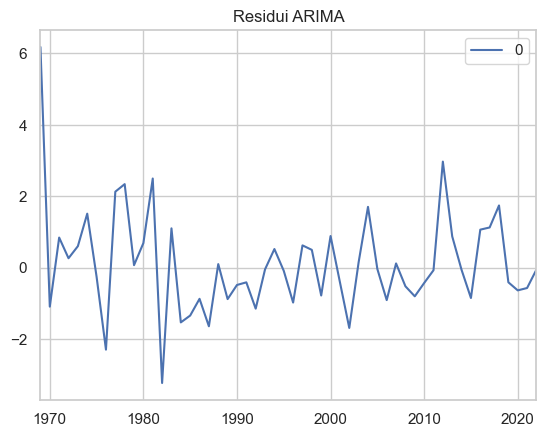

In [85]:
from statsmodels.tsa.arima.model import ARIMA
# Visualizza il grafico delle serie temporali
mins_played["Minuti giocati normalizzati FIX"].plot()
plt.title('Minuti giocati da calciatori Under-21')
plt.show()

# Esegui l'analisi ARIMA
model = ARIMA(mins_played["Minuti giocati normalizzati FIX"], order=(1, 1, 1))  # Ordine p, d, q
results = model.fit()

# Stampa il riassunto dell'analisi ARIMA
print(results.summary())

# Visualizza il grafico dei residui
residuals = pd.DataFrame(results.resid)
residuals.plot()
plt.title('Residui ARIMA')
plt.show()

In [101]:

# Esegui il test di Kolmogorov-Smirnov per verificare se i dati seguono una distribuzione normale
# Sostituisci 'minuti_giocati' con il nome della colonna dei minuti giocati nel tuo DataFrame
ks_statistic, ks_p_value = kstest(mins_played['Minuti giocati FIX'], mins_played['Minuti giocati totali'])

# Valuta il risultato del test
alpha = 0.05  # Livello di significatività
if ks_p_value < alpha:
    print("I dati NON seguono una distribuzione normale.")
else:
    print("I dati seguono una distribuzione normale.")

# Stampare la statistica KS e il valore p per ulteriori riferimenti
print("Statistica KS:", ks_statistic)
print("Valore p:", ks_p_value)

I dati NON seguono una distribuzione normale.
Statistica KS: 1.0
Valore p: 8.04576932703266e-32


In [61]:
# Aggiungi una colonna con gli anni numerici per l'analisi di regressione
mins_played['Anno_Numerico'] = mins_played.index.year


# Esegui l'analisi di regressione
X = mins_played[['Anno_Numerico','Minuti giocati totali']]
X = sm.add_constant(X)  # Aggiungi una costante (intercetta) al modello
y = mins_played['Minuti giocati FIX']

model = sm.OLS(y, X).fit()

# Stampa il risultato dell'analisi
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     Minuti giocati FIX   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.8309
Date:                Tue, 24 Oct 2023   Prob (F-statistic):              0.441
Time:                        14:13:54   Log-Likelihood:                -562.22
No. Observations:                  54   AIC:                             1130.
Df Residuals:                      51   BIC:                             1136.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -3.685e+

In [103]:
# Esegui l'ANOVA
f_statistic, p_value = stats.f_oneway(mins_played["Minuti giocati normalizzati FIX"],mins_played["Minuti giocati normalizzati Italiani"],mins_played["Minuti giocati normalizzati Stranieri"])

# Stampa i risultati
print("Statistiche ANOVA:")
print("F-statistic:", f_statistic)
print("P-value:", p_value)
# Confronta il p-value con il livello di significatività (solitamente 0.05)
alpha = 0.05
if p_value < alpha:
    print("Il p-value è inferiore a", alpha, " - ci sono variazioni statisticamente significative.")
else:
    print("Il p-value è maggiore di", alpha, " - non ci sono variazioni statisticamente significative.")

Statistiche ANOVA:
F-statistic: 96.40203711370525
P-value: 3.8032304381998185e-28
Il p-value è inferiore a 0.05  - ci sono variazioni statisticamente significative.


In [104]:
dati = np.array([46532, 43779, 45514, 49195, 61861, 51621])

# Specifica la distribuzione teorica o la distribuzione di riferimento
# Ad esempio, se stai cercando di confrontare con una distribuzione normale, puoi usare:
# distribuzione_di_riferimento = 'norm'

# Esegui il test Kolmogorov-Smirnov
kstest(mins_played["Minuti giocati normalizzati FIX"],mins_played["Minuti giocati normalizzati Italiani"])

KstestResult(statistic=0.48148148148148145, pvalue=4.884245601977775e-06, statistic_location=4.2366310160427805, statistic_sign=-1)

In [61]:
f_oneway(mins_played["Minuti giocati normalizzati FIX"],axis=1)
#get all columns of the dataframe and put on the function f_oneway


TypeError: at least two inputs are required; got 1.

In [39]:
stats.kstest(mins_played['Minuti giocati normalizzati FIX'], stats.norm.cdf)

KstestResult(statistic=0.9999999999999942, pvalue=0.0, statistic_location=7.7215686274509805, statistic_sign=-1)


INFO: To supress printing the parameers in beast123(),   set extra.printOptions = 0  
INFO: To supress printing the parameers in beast(),      set print.options = 0 
INFO: To supress printing the parameers in beast.irreg(),set print.options = 0 
INFO: To supress warning messages in beast123(),         set extra.quiet = 1  
INFO: To supress warning messages in beast(),            set quiet = 1 
INFO: To supress warning messages in beast.irreg(),      set quiet = 1 

#--------------------------------------------------#
#       Brief summary of Input Data                #
#--------------------------------------------------#
Data Dimension: One signal of length 54
IsOrdered     : Yes, ordered in time
IsRegular     : Yes, evenly spaced at interval of  1 year = 12 months = 365 days
hasSeasonCmpnt: False | no periodic or seasonal component. The model Y=Trend+Error is fitted.
HasOutlierCmpt: False | If true, Y=Trend+Outlier+Error (experimental) is fitted instead of Y=Trend+Error 
Detrend     

C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\Rbeast\plotbeast.py:294: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


#####################################################################
#                      Seasonal  Changepoints                       #
#####################################################################
 No seasonal/periodic component present (i.e., season='none')


#####################################################################
#                      Trend  Changepoints                          #
#####################################################################
.-------------------------------------------------------------------.
| Ascii plot of probability distribution for number of chgpts (ncp) |
.-------------------------------------------------------------------.
|Pr(ncp = 0 )=0.004|*                                               |
|Pr(ncp = 1 )=0.068|**********                                      |
|Pr(ncp = 2 )=0.261|*************************************           |
|Pr(ncp = 3 )=0.338|*********************************************** |
|Pr(ncp = 4 )=0.214|******

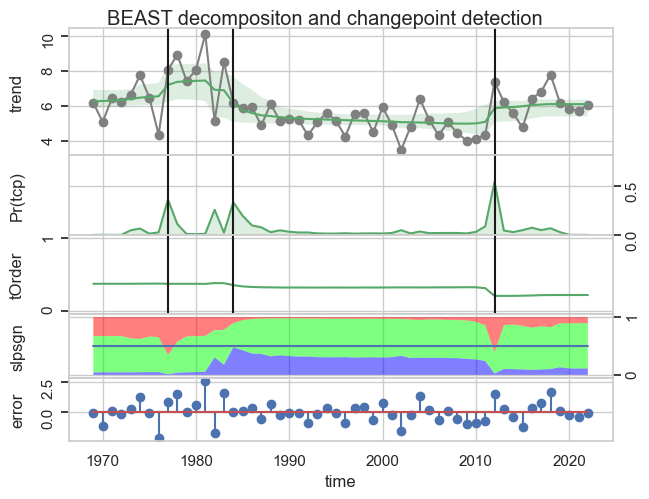

In [51]:
import Rbeast as rb
import numpy as np
o=rb.beast(mins_played['Minuti giocati normalizzati FIX'], start=1969, deltat=1,period="1.0 year")
rb.plot(o)
rb.print(o)

In [78]:
#esegue la media dei minuti giocati normalizzati ogni 8 stagioni
mins_played_10=pd.DataFrame(columns=["Minuti giocati normalizzati TM"])
mins_played_10.loc["1969-1976","Minuti giocati normalizzati TM"]=mins_played["Minuti giocati normalizzati TM"][0:8].mean()
mins_played_10.loc["1977-1984","Minuti giocati normalizzati TM"]=mins_played["Minuti giocati normalizzati TM"][8:16].mean()
mins_played_10.loc["1985-1992","Minuti giocati normalizzati TM"]=mins_played["Minuti giocati normalizzati TM"][16:24].mean()
mins_played_10.loc["1993-2000","Minuti giocati normalizzati TM"]=mins_played["Minuti giocati normalizzati TM"][24:32].mean()
mins_played_10.loc["2001-2008","Minuti giocati normalizzati TM"]=mins_played["Minuti giocati normalizzati TM"][32:40].mean()
mins_played_10.loc["2009-2017","Minuti giocati normalizzati TM"]=mins_played["Minuti giocati normalizzati TM"][40:48].mean()
mins_played_10.loc["2017-2022","Minuti giocati normalizzati TM"]=mins_played["Minuti giocati normalizzati TM"][48:].mean()

mins_played_10.loc["1969-1976","Minuti giocati normalizzati FIX"]=mins_played["Minuti giocati normalizzati FIX"][0:8].mean()
mins_played_10.loc["1977-1984","Minuti giocati normalizzati FIX"]=mins_played["Minuti giocati normalizzati FIX"][8:16].mean()
mins_played_10.loc["1985-1992","Minuti giocati normalizzati FIX"]=mins_played["Minuti giocati normalizzati FIX"][16:24].mean()
mins_played_10.loc["1993-2000","Minuti giocati normalizzati FIX"]=mins_played["Minuti giocati normalizzati FIX"][24:32].mean()
mins_played_10.loc["2001-2008","Minuti giocati normalizzati FIX"]=mins_played["Minuti giocati normalizzati FIX"][32:40].mean()
mins_played_10.loc["2009-2017","Minuti giocati normalizzati FIX"]=mins_played["Minuti giocati normalizzati FIX"][40:48].mean()
mins_played_10.loc["2017-2022","Minuti giocati normalizzati FIX"]=mins_played["Minuti giocati normalizzati FIX"][48:].mean()


mins_played_10.head(8)

,Minuti giocati normalizzati TM,Minuti giocati normalizzati FIX
1969-1976,6.403704,6.149032
1977-1984,8.055366,7.807534
1985-1992,6.037921,5.355817
1993-2000,5.629846,5.216522
2001-2008,5.319778,4.841484
2009-2017,5.561553,5.365032
2017-2022,6.612219,6.409534


## Grafici

Text(0.5, 1.0, 'Minuti giocati dai giocatori Under 21 in Serie A ogni 8 anni')

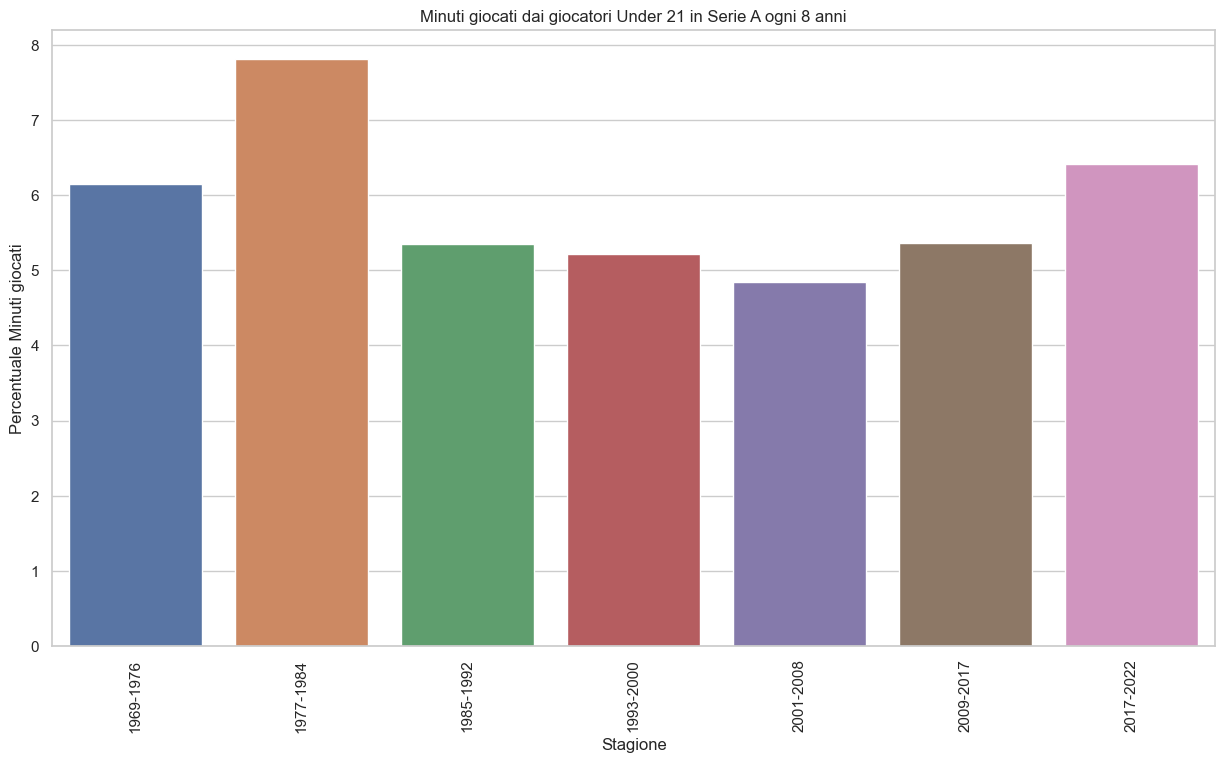

In [10]:
plt.figure(figsize=(15,8))
sns.barplot(x=mins_played_10.index, y=mins_played_10["Minuti giocati normalizzati FIX"])
plt.xticks(rotation=90)
plt.xlabel("Stagione")
plt.ylabel("Percentuale Minuti giocati")
plt.title("Minuti giocati dai giocatori Under 21 in Serie A ogni 8 anni")

C:\Users\franc\AppData\Local\Temp\ipykernel_19852\1339171240.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(mins_played["Minuti giocati normalizzati FIX"], shade=True, color='blue', label='Minuti giocati')


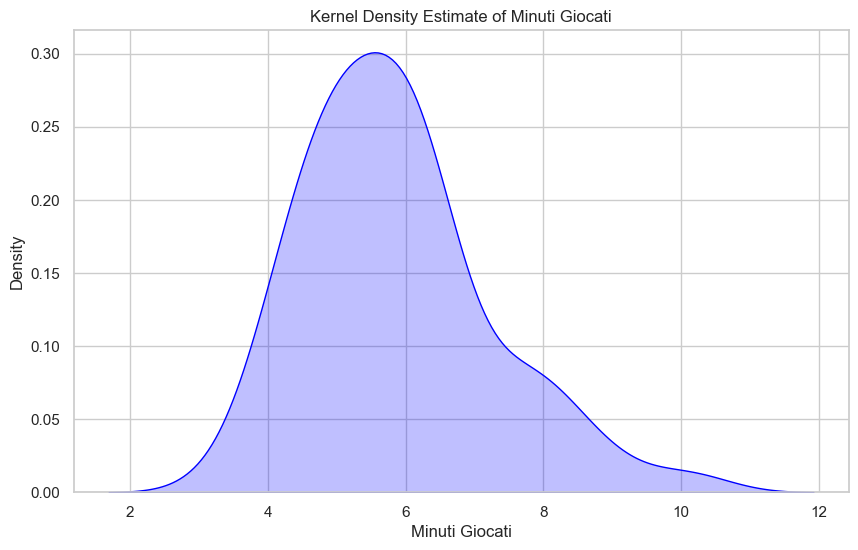

In [14]:
plt.figure(figsize=(10, 6))
sns.kdeplot(mins_played["Minuti giocati normalizzati FIX"], shade=True, color='blue', label='Minuti giocati')

# Customize the plot
plt.title('Kernel Density Estimate of Minuti Giocati')
plt.xlabel('Minuti Giocati')
plt.ylabel('Density')

# Show the plot
plt.show()


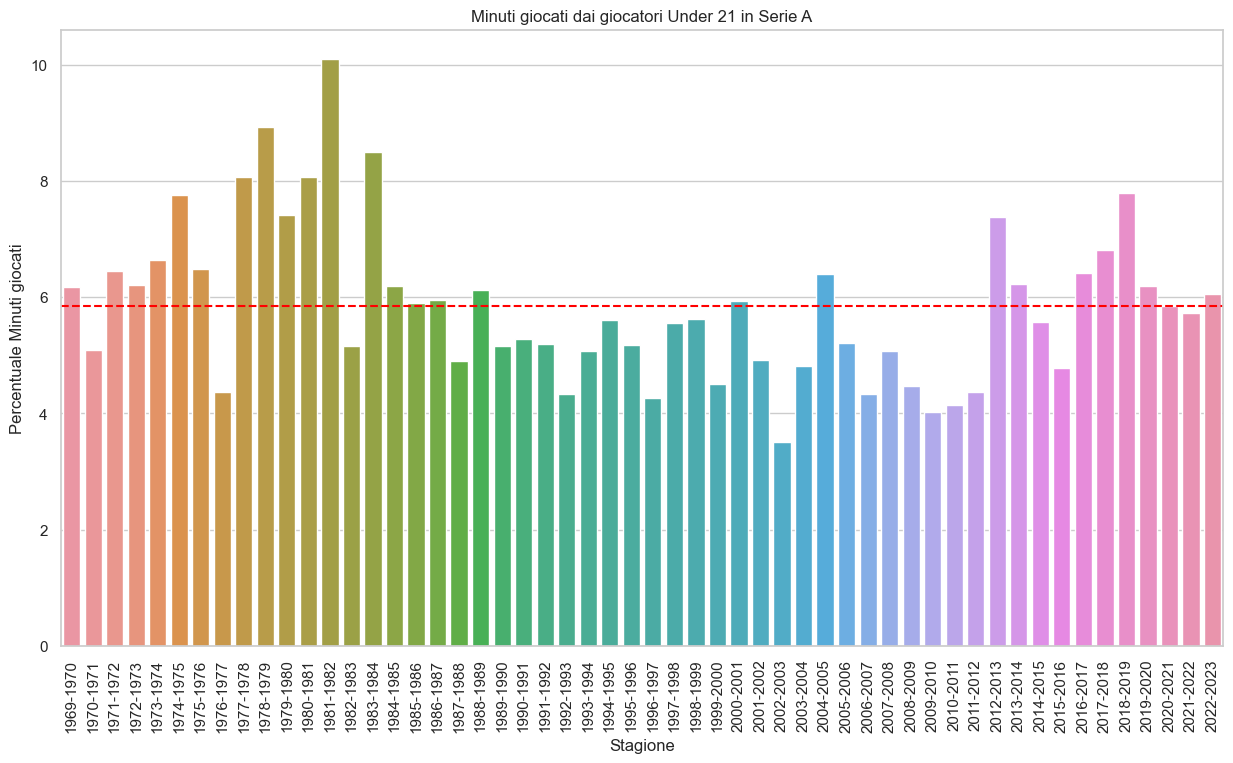

In [64]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15,8))
sns.barplot(x=mins_played.index, y=mins_played["Minuti giocati normalizzati FIX"])
plt.xticks(rotation=90)
plt.xlabel("Stagione")
plt.ylabel("Percentuale Minuti giocati")
plt.title("Minuti giocati dai giocatori Under 21 in Serie A")
#print line mean
plt.axhline(mins_played["Minuti giocati normalizzati FIX"].mean(), color='red', linestyle='--')






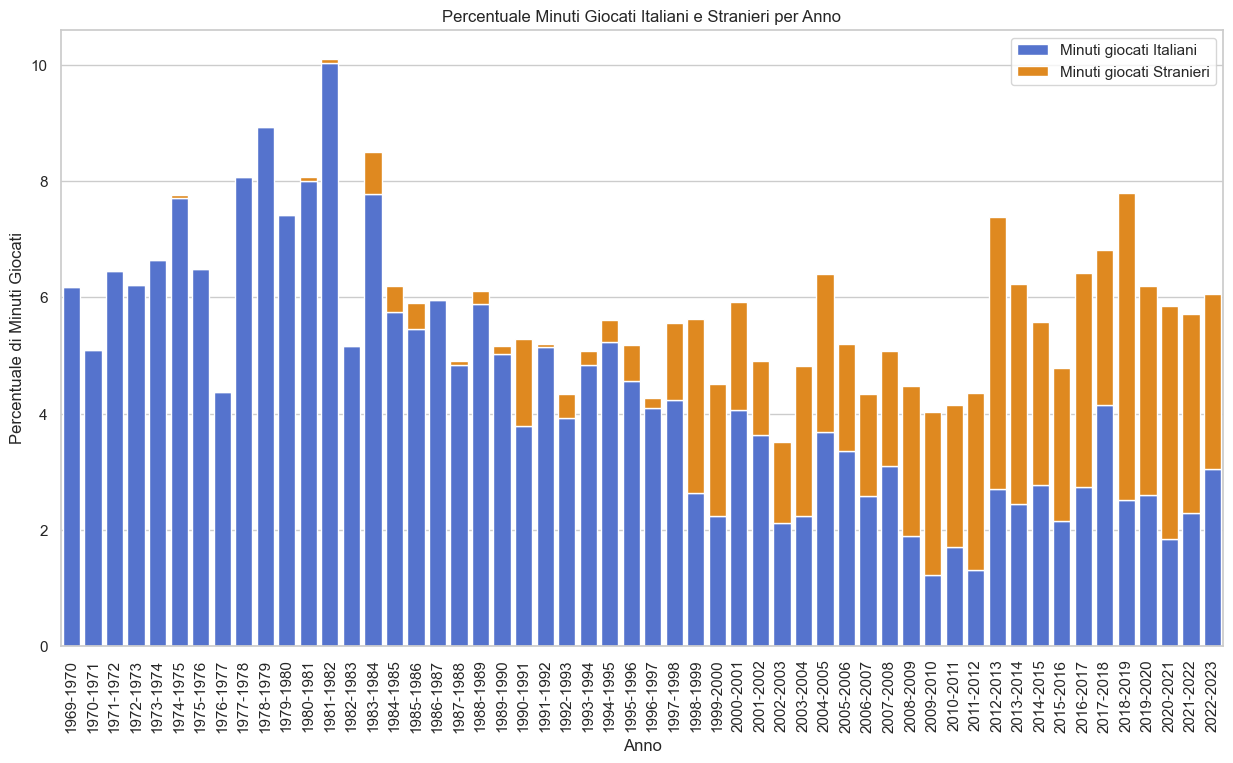

In [ ]:
# Supponiamo che tu abbia un DataFrame chiamato 'mins_played' con le colonne "Minuti giocati normalizzati Italiani" e "Minuti giocati normalizzati Stranieri"

plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")
# Crea l'istogramma utilizzando Seaborn
sns.barplot(data=mins_played, x=mins_played.index, y="Minuti giocati normalizzati Italiani", color="royalblue",label="Minuti giocati Italiani")
sns.barplot(data=mins_played, x=mins_played.index, y="Minuti giocati normalizzati Stranieri",color="darkorange",label="Minuti giocati Stranieri", bottom=mins_played["Minuti giocati normalizzati Italiani"])

# Aggiungi etichette e titoli
plt.xticks(rotation=90)
plt.xlabel('Anno')
plt.ylabel('Percentuale di Minuti Giocati')
plt.title('Percentuale Minuti Giocati Italiani e Stranieri per Anno')

# Aggiungi legenda
plt.legend()

# Mostra l'istogramma
plt.show()

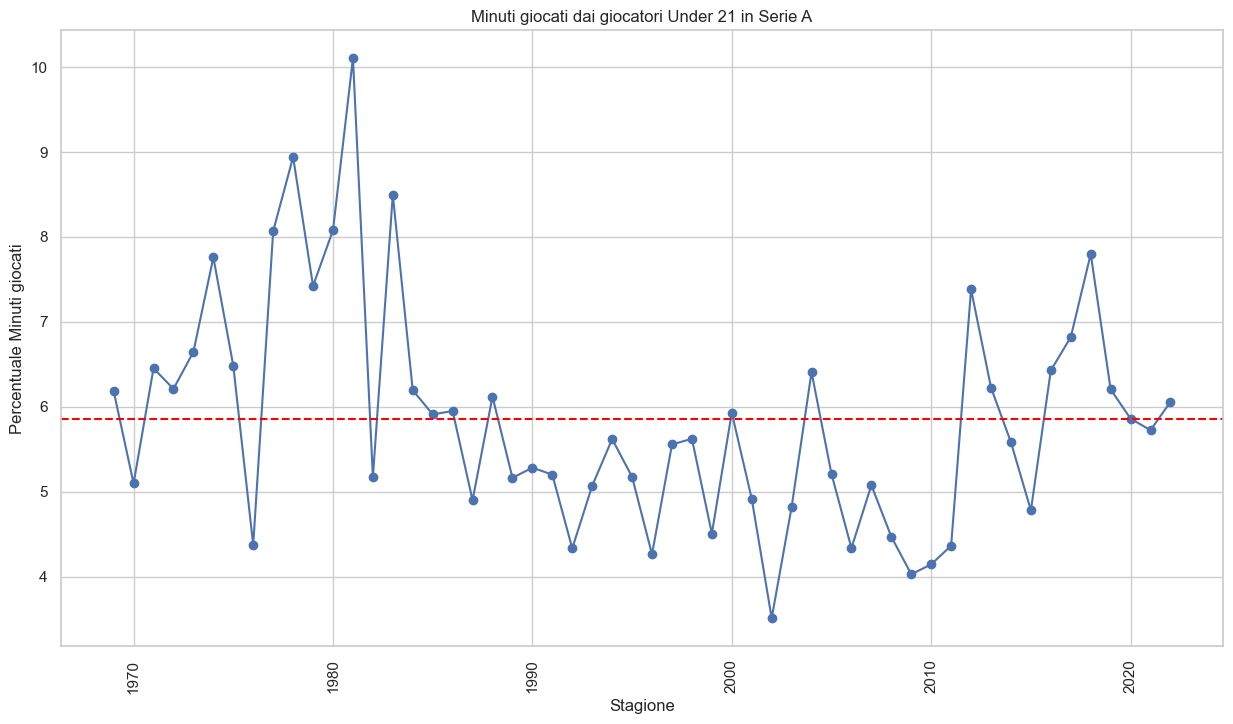

In [16]:
#print a line plot with the minutes played normalized with line mean and marker 
plt.figure(figsize=(15,8))
plt.plot(mins_played.index,mins_played["Minuti giocati normalizzati FIX"],marker='o')
plt.xticks(rotation=90)
plt.xlabel("Stagione")
plt.ylabel("Percentuale Minuti giocati")
plt.title("Minuti giocati dai giocatori Under 21 in Serie A")
#print line mean
plt.axhline(mins_played["Minuti giocati normalizzati FIX"].mean(), color='red', linestyle='--')
